# Plotting temperature and photosynthesis-related GO term counts, normalised by number of InterPro annotations, for Ocean Sampling Day (OSD) 2014: amplicon and metagenome sequencing study from the June solstice in the year 2014, project PRJEB8682

The following task shows how to analysie metadata and annotations retrieved from the EMG API and combined on the fly to generate the visualisations.

In [1]:
import copy
try:
    from urllib import urlencode
except ImportError:
    from urllib.parse import urlencode
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from jsonapi_client import Session, Filter

API_BASE = 'https://www.ebi.ac.uk/metagenomics/api/v0.2/'

List all runs
https://www.ebi.ac.uk/metagenomics/api/v0.2/pipelines/4.0/runs?experiment_type=metagenomic&study_accession=ERP009703

In [3]:
def find_metadata(metadata, key):
    """
    Extract metadata value for given key
    """
    for m in metadata:
        if m.var_name.lower() == key.lower():
            return m.var_value
    return None


metadata_key = 'temperature'
normilize_key = 'Predicted CDS with InterProScan match'

# map GO terms to the temperature
result = {}


with Session(API_BASE) as s:

    # list of runs missing metadata
    missing_meta = list()
    
    print('Loading data from API.', end='', flush=True)

    # preparing url
    params = {
        'experiment_type': 'metagenomic',
        'study_accession': 'ERP009703',
    }
    f = Filter(urlencode(params))
    # list runs
    for anls in s.iterate('pipelines/4.0/analysis', f):
        print('.', end='', flush=True)

        # find temperature
        m_value = float(find_metadata(anls.sample.metadata, metadata_key))
        if m_value is None:
            # missing value, skip run!
            missing_meta.append(anls.accession)
            continue

        _pcds = int(find_metadata(anls.metadata, normilize_key))
        if _pcds is None:
            # missing value, skip run!
            continue

        try:
            result[m_value]
        except KeyError:
            result[m_value] = {}

        # list a summary of GO terms derived from InterPro matches
        rt = "runs/%s/pipelines/%s/go-slim" % (anls.accession, anls.pipeline_version)
        af = Filter(urlencode({'page_size': 100}))
        for ann in s.iterate(rt, af):
            try:
                result[m_value][ann.accession]
            except KeyError:
                result[m_value][ann.accession] = list()
            # normalize annotation counts, adjusting value
            _norm = int(ann.count)/_pcds
            # assign value
            result[m_value][ann.accession].append(_norm)

    print("DONE")
    print("Missing: ", missing_meta)

Loading data from API.......................................................................................................................................................DONE
Missing:  []


### Clean up data

In [4]:
# remove invalid temperatures
for k in copy.deepcopy(list(result.keys())):
    if k > 2000:
        del result[k]
# average value of the same temperature
for k in result:
    for k1 in result[k]:
        result[k][k1] = np.mean(result[k][k1])

### Plot

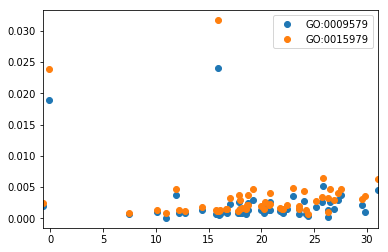

In [5]:
df = DataFrame(result).T
df_go = df[['GO:0009579','GO:0015979']].copy()
df_go = df_go.dropna()

df_go.plot(y=['GO:0009579', 'GO:0015979'], use_index=True, style='o')

plt.show()

### Calculate correlation

In [6]:
from scipy.stats import spearmanr
x = df_go.index.tolist()
correl = []
correl_p = []
for k in df_go.keys():
    y = list(df_go[k])
    rho, p = spearmanr(x, y)

    correl.append(rho)
    correl_p.append(p)
df_go.loc['rho'] = correl
df_go.loc['p'] = correl_p

In [7]:
df_go

,GO:0009579,GO:0015979
-0.72,0.001951,0.002464
-0.1,0.018931,0.023951
7.5,0.000704,0.000889
10.1,0.000973,0.001335
11.0,0.000080,0.000829
11.9,0.003677,0.004768
12.2,0.000883,0.001318
12.8,0.000811,0.001239
14.38,0.001396,0.001843
15.7139,0.000660,0.001278
